In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from itertools import count
from IPython.display import display, clear_output

In [4]:
import random
import math

In [5]:
from environment.cube import Cube
from training.replaymem import ReplayMemory, Transition
from training.model import DQN

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
# BATCH_SIZE: number of transitions sampled from the replay buffer in each training step
# GAMMA: discount factor
# EPS_START: starting value of epsilon
# EPS_END: final value of epsilon
# EPS_DECAY: controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU: update rate of the target network (in the discrete lpf equation)
# LR: learning rate of the Adam optimizer
# MAX_DURATION: maximum step count of an episode before its truncated

BATCH_SIZE = 16
GAMMA = 0.9
EPS_START = 0.15
EPS_END = 0.05
EPS_DECAY = 15_000
TAU = 0.005
LR = 1e-4
MAX_DURATION = 9

# Get number of actions from cube (all possible rotations)
cube = Cube()
solved_state = cube.get_state()
n_actions = len(cube.moves)
# Get the number of state observations
n_observations = cube.state.size

n_actions, n_observations

(12, 27)

In [8]:
# create target and policy networks
# target network is just policy network with a discrete low pass filter
# its used for stability
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# initialize adam optimizer and replay memory
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(128)

# Define functions

`select_action(state)`:  selects an action using epsilon-greedy, using the policy approximation network


In [9]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0, n_actions-1)]], device=device, dtype=torch.long)


def select_action_greedy(state):
    return policy_net(state).max(1).indices.view(1, 1)


`plot_durations(show_result=Fals)`: plots a graph of the duration of each episode (to see duration decreasing as model learns)

In [10]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display(plt.gcf())
        clear_output(wait=True)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch
    # from batch array [ transition(state, next, reward, action), transition(state, next, reward, action) ]
    # to transition( [states], [next_states], [rewards], [actions] )
    batch = Transition(*zip(*transitions))

    # create a list of all next states that arent final (only unsolved cube states),
    # and a bit mask for their indices to be able to merge later
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # get Q(s_t, a), which is the Q value in state s_t when action a is taken
    # action a is the action that policy_net picks based on its approximation of Q
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # get V(s_t+1), which is the maximum Q value in the next_state s_t+1
    # uses the low pass filtered target_net
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # intuition is that Q should be the reward of the action it will take in the current state, 
    # and the discounted Q of the next state after that action
    # expected Q =  r + gamma*V
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss between expected Q (current reward from environment + discounted future reward estimated by network)
    # Vs the Q the policy network predicted
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Training
Traing the model for num_episodes

Complete


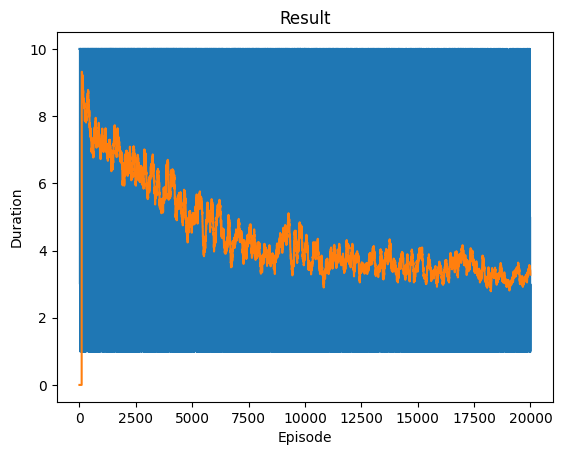

In [12]:
num_episodes = 20_000
num_logs = 50

for i_log in range(num_logs):
    for i_episode in range(num_episodes//num_logs):
        # Initialize the environment and get its state
        cube.reset()
        state = cube.shuffle(3)
        state = torch.tensor(state, dtype=torch.int64, device=device).unsqueeze(0)
        for t in count():
            # get next action
            action_index = select_action(state)
            action = cube.moves[action_index.item()]
            next_state = action()

            # check if cube is solved or if max steps reached
            terminated = (next_state == solved_state).all()
            truncated = (t == MAX_DURATION)
            done = terminated or truncated

            # give reward if cube is solved only
            reward = 1 if terminated else 0
            reward = torch.tensor([reward], device=device)
            
            # if solved, there is no next state
            if not terminated: next_state = torch.tensor(next_state, device=device).unsqueeze(0)
            else: next_state = None
            
            # Store the current transition in replay memory
            memory.push(state, action_index, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            # low pass filter
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                break

    # log
    plot_durations()

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Validation
Randomly shuffles cubes and tests how many the model was able to solve.

In [20]:
NUM_CUBES = 500
SHUFFLE_DISTANCE = 3
VALIDATION_LIMIT = 5

solved = 0

for i in range(NUM_CUBES):
    # shuffle cube
    cube.reset()
    state = cube.shuffle(SHUFFLE_DISTANCE)

    state = torch.tensor(state, dtype=torch.int64, device=device).unsqueeze(0)
    done = False

    for i in count():
        # select an action for the current state using model
        action_index = select_action_greedy(state)
        action = cube.moves[action_index.item()]
        next_state = action()

        # check if solved or too many steps
        terminated = (next_state == solved_state).all()
        truncated = i > VALIDATION_LIMIT
        done = terminated or truncated
        if done: break

        next_state = torch.tensor(next_state, device=device).unsqueeze(0)
        state = next_state

    if terminated: solved += 1

print(f'Accuracy: {solved/NUM_CUBES}')

Accuracy: 0.954


# Inference
Finally, using the previously trained model, randomly shuffle a cube, and see if the model is able to solve it in a certain number of steps and show the shuffling pattern and solving pattern, and write down the pattern for shuffling and solving to see the model in action.

In [14]:

print('shuffling...')
cube.reset()
state = cube.shuffle(SHUFFLE_DISTANCE, True)

print('solving...')
state = torch.tensor(state, dtype=torch.int64, device=device).unsqueeze(0)
done = False
for i in count():
    action_index = select_action_greedy(state)
    action = cube.moves[action_index.item()]
    next_state = action()
    print(action.__name__, end=' ')

    terminated = (next_state == solved_state).all()
    truncated = i > VALIDATION_LIMIT
    done = terminated or truncated
    if done: break

    next_state = torch.tensor(next_state, device=device).unsqueeze(0)
    state = next_state

if truncated: print('failed')
else: print('success')

shuffling...
down front_p down_p 
solving...
front front front_p front front_p front front_p failed
